# Forecasting Walmart Sales

### **Table of Contents**
* [<span style="color:#A690A4"> 0. Executive Summary](#exe_sum)
* [<span style="color:#A690A4"> 1. Introduction](#intro)
* [<span style="color:#A690A4"> 2. Collect & Clean Data](#collect)
* [<span style="color:#A690A4"> 3. Wrangle & Explore Data](#process)
* [<span style="color:#A690A4"> 4. Forecast Sales](#predict)
* [<span style="color:#A690A4"> 5. Conclusion](#conclusion)

# <span style="color:#5E6997">Executive Summary</span> <a class="anchor" id="exe_sum"></a>

# <span style="color:#5E6997">Introduction</span> <a class="anchor" id="intro"></a>

# <span style="color:#5E6997">Collect & Clean Data</span> <a class="anchor" id="collect"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [2]:
# Define file paths
features_path = "/kaggle/input/walmart-sales-forecast/features.csv"
stores_path   = "/kaggle/input/walmart-sales-forecast/stores.csv"
train_path    = "/kaggle/input/walmart-sales-forecast/train.csv"
test_path     = "/kaggle/input/walmart-sales-forecast/test.csv"

# Load datasets
features = pd.read_csv(features_path)
stores   = pd.read_csv(stores_path)
train    = pd.read_csv(train_path)
test     = pd.read_csv(test_path)

In [3]:
# Convert the 'Date' column to datetime format
features["Date"] = pd.to_datetime(features["Date"], format="%Y-%m-%d")
train["Date"] = pd.to_datetime(train["Date"], format="%Y-%m-%d")
test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d")

### Store Data

In [4]:
stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [5]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [6]:
def display_feature_range(df):
    """
    Display the range of values for each column in a DataFrame.
    For numeric (non-boolean) columns, prints the minimum, maximum, and range.
    For non-numeric or boolean columns, prints the unique values.
    """
    for col in df.columns:
        print("=" * 40)
        print(f"Feature: {col}")
        
        # Check for numeric columns excluding booleans
        if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
            col_min = df[col].min()
            col_max = df[col].max()
            print(f"Min: {col_min}")
            print(f"Max: {col_max}")
            print(f"Range: {col_max - col_min}")
        else:
            unique_vals = df[col].unique()
            print("Unique values:", unique_vals)
        print("=" * 40, "\n")

In [7]:
# Call the function with the stores dataset
display_feature_range(stores)

Feature: Store
Min: 1
Max: 45
Range: 44

Feature: Type
Unique values: ['A' 'B' 'C']

Feature: Size
Min: 34875
Max: 219622
Range: 184747



### Features Data

In [8]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [9]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [10]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [12]:
# Define the list of MarkDown columns
markdown_cols = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]

# Fill missing values in the MarkDown columns with 0
features[markdown_cols] = features[markdown_cols].fillna(0)

# Optionally, display info to verify that missing values have been filled
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     8190 non-null   float64       
 5   MarkDown2     8190 non-null   float64       
 6   MarkDown3     8190 non-null   float64       
 7   MarkDown4     8190 non-null   float64       
 8   MarkDown5     8190 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [13]:
# Create boolean masks where True indicates a missing value
mask_cpi = features['CPI'].isna()
mask_unemployment = features['Unemployment'].isna()

# Check if both masks are exactly the same
if mask_cpi.equals(mask_unemployment):
    print("CPI and Unemployment have the exact same missing value pattern.")
else:
    print("CPI and Unemployment have different missing value patterns.")

CPI and Unemployment have the exact same missing value pattern.


In [14]:
# Rows where CPI  is missing
missing_mask = features['CPI'].isna() 
missing_rows = features[missing_mask]
print(missing_rows)

      Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
169       1 2013-05-03        66.66       3.386    2298.63       2.00   
170       1 2013-05-10        63.90       3.392    4624.61      83.88   
171       1 2013-05-17        69.53       3.454   16170.50      92.00   
172       1 2013-05-24        77.19       3.494    7959.89     178.00   
173       1 2013-05-31        78.02       3.466    2369.77     142.45   
...     ...        ...          ...         ...        ...        ...   
8185     45 2013-06-28        76.05       3.639    4842.29     975.03   
8186     45 2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45 2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45 2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45 2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
169      129.90      55.46    1301.04  NaN           

In [15]:
# Focus on Store 1 (or whichever store is plotted)
store1 = features[features['Store'] == 1].copy()
store1 = store1.sort_values('Date')

# Inspect data for the time frame around the suspicious jump
suspicious_range = store1[(store1['Date'] >= "2013-04-01") & (store1['Date'] <= "2013-08-31")]
print(suspicious_range[['Date', 'CPI']])

          Date        CPI
165 2013-04-05  225.08654
166 2013-04-12  225.17016
167 2013-04-19  225.17016
168 2013-04-26  225.17016
169 2013-05-03        NaN
170 2013-05-10        NaN
171 2013-05-17        NaN
172 2013-05-24        NaN
173 2013-05-31        NaN
174 2013-06-07        NaN
175 2013-06-14        NaN
176 2013-06-21        NaN
177 2013-06-28        NaN
178 2013-07-05        NaN
179 2013-07-12        NaN
180 2013-07-19        NaN
181 2013-07-26        NaN


In [16]:
print(features[['Date', 'Store', 'CPI', 'Unemployment']].tail(30))

           Date  Store         CPI  Unemployment
8160 2013-01-04     45  192.659622         8.625
8161 2013-01-11     45  192.759980         8.625
8162 2013-01-18     45  192.809507         8.625
8163 2013-01-25     45  192.838701         8.625
8164 2013-02-01     45  192.867895         8.625
8165 2013-02-08     45  192.897089         8.625
8166 2013-02-15     45  192.943471         8.625
8167 2013-02-22     45  193.032822         8.625
8168 2013-03-01     45  193.122173         8.625
8169 2013-03-08     45  193.211524         8.625
8170 2013-03-15     45  193.296277         8.625
8171 2013-03-22     45  193.369533         8.625
8172 2013-03-29     45  193.442790         8.625
8173 2013-04-05     45  193.516047         8.335
8174 2013-04-12     45  193.589304         8.335
8175 2013-04-19     45  193.589304         8.335
8176 2013-04-26     45  193.589304         8.335
8177 2013-05-03     45         NaN           NaN
8178 2013-05-10     45         NaN           NaN
8179 2013-05-17     

In [17]:
# Set Date as the index for interpolation
features.set_index("Date", inplace=True)

# Step 1: Apply Forward-Fill and Backward-Fill at the Global Level
features[['CPI', 'Unemployment']] = features[['CPI', 'Unemployment']].ffill().bfill()

# Step 2: Apply Linear Interpolation Per Store
features = (
    features.groupby("Store", group_keys=False)  # Ensure per-store interpolation
            .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))  
)

# Reset index so Date becomes a column again
features.reset_index(inplace=True)

<ipython-input-17-80f2677e93c6>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))


In [18]:
print(features[['Date', 'CPI', 'Unemployment']].tail(30))

           Date         CPI  Unemployment
8160 2013-01-04  192.659622         8.625
8161 2013-01-11  192.759980         8.625
8162 2013-01-18  192.809507         8.625
8163 2013-01-25  192.838701         8.625
8164 2013-02-01  192.867895         8.625
8165 2013-02-08  192.897089         8.625
8166 2013-02-15  192.943471         8.625
8167 2013-02-22  193.032822         8.625
8168 2013-03-01  193.122173         8.625
8169 2013-03-08  193.211524         8.625
8170 2013-03-15  193.296277         8.625
8171 2013-03-22  193.369533         8.625
8172 2013-03-29  193.442790         8.625
8173 2013-04-05  193.516047         8.335
8174 2013-04-12  193.589304         8.335
8175 2013-04-19  193.589304         8.335
8176 2013-04-26  193.589304         8.335
8177 2013-05-03  193.589304         8.335
8178 2013-05-10  193.589304         8.335
8179 2013-05-17  193.589304         8.335
8180 2013-05-24  193.589304         8.335
8181 2013-05-31  193.589304         8.335
8182 2013-06-07  193.589304       

In [19]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          8190 non-null   datetime64[ns]
 1   Store         8190 non-null   int64         
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     8190 non-null   float64       
 5   MarkDown2     8190 non-null   float64       
 6   MarkDown3     8190 non-null   float64       
 7   MarkDown4     8190 non-null   float64       
 8   MarkDown5     8190 non-null   float64       
 9   CPI           8190 non-null   float64       
 10  Unemployment  8190 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


<ipython-input-20-9b373cd380b2>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index("Date").interpolate(method='linear', limit_direction='both').reset_index())


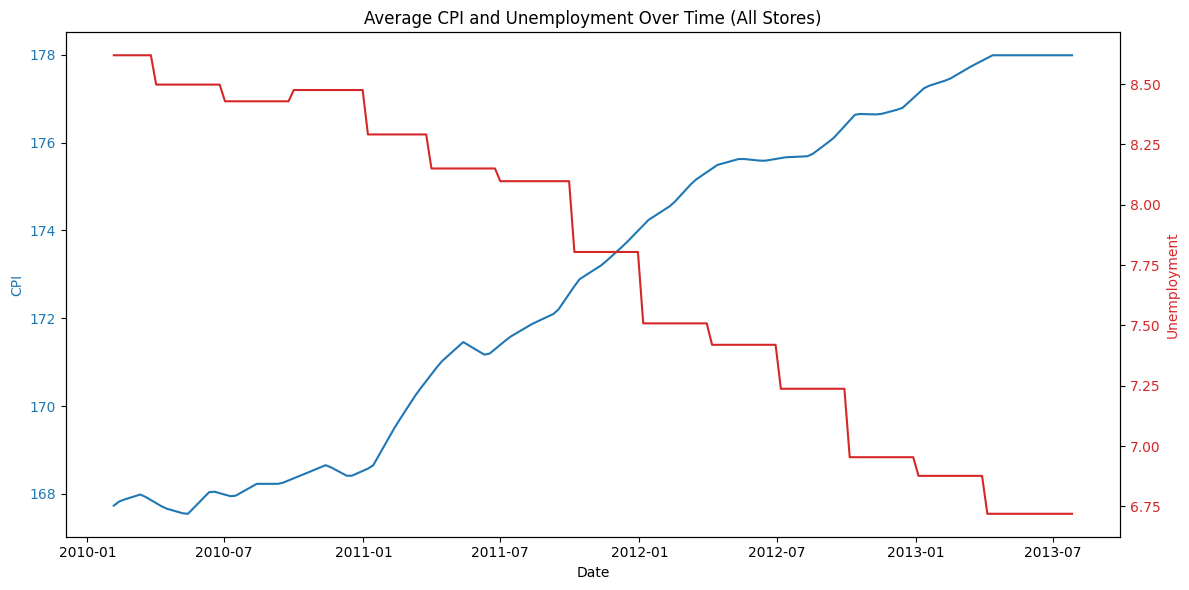

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ensure Date is in datetime format
features['Date'] = pd.to_datetime(features['Date'])

# 2. Sort by Store and Date (only needed once)
features.sort_values(["Store", "Date"], inplace=True)

# 3. Apply Linear Interpolation Per Store (Fix: Use "Date" as the index)
features = (
    features.groupby("Store", group_keys=False)  # Group by store
            .apply(lambda g: g.set_index("Date").interpolate(method='linear', limit_direction='both').reset_index())  
)

# 4. Aggregate to get daily averages across all stores (ensuring one row per date)
daily_avg = features.groupby('Date', as_index=False).agg({
    'CPI': 'mean',
    'Unemployment': 'mean'
})
daily_avg.sort_values('Date', inplace=True)

# 5. Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12,6))

# CPI on primary y-axis
color_cpi = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI", color=color_cpi)
ax1.plot(daily_avg['Date'], daily_avg['CPI'], color=color_cpi, label='Avg CPI')
ax1.tick_params(axis='y', labelcolor=color_cpi)

# Unemployment on secondary y-axis
ax2 = ax1.twinx()
color_unemp = 'tab:red'
ax2.set_ylabel("Unemployment", color=color_unemp)
ax2.plot(daily_avg['Date'], daily_avg['Unemployment'], color=color_unemp, label='Avg Unemployment')
ax2.tick_params(axis='y', labelcolor=color_unemp)

plt.title("Average CPI and Unemployment Over Time (All Stores)")
fig.tight_layout()
plt.savefig("CPI_Unemployment_all_stores.jpg", format="jpg", dpi=300)
plt.show()


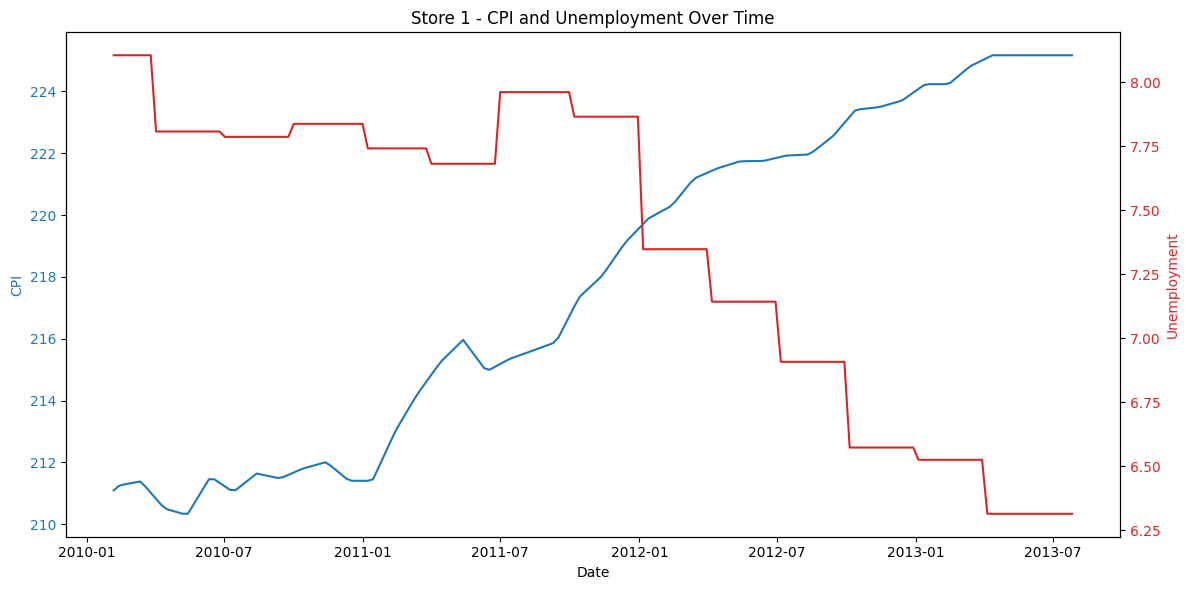

In [21]:

# Assuming 'features' is your DataFrame with interpolated CPI and Unemployment

# Choose the store you want to visualize (e.g., Store 1)
store_id = 1
store_df = features[features['Store'] == store_id].copy()

# Sort by Date to ensure the time series is in order
store_df.sort_values('Date', inplace=True)

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot CPI on the primary y-axis
color_cpi = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI", color=color_cpi)
ax1.plot(store_df['Date'], store_df['CPI'], color=color_cpi, label='CPI')
ax1.tick_params(axis='y', labelcolor=color_cpi)

# Create a second y-axis for Unemployment
ax2 = ax1.twinx()
color_unemp = 'tab:red'
ax2.set_ylabel("Unemployment", color=color_unemp)
ax2.plot(store_df['Date'], store_df['Unemployment'], color=color_unemp, label='Unemployment')
ax2.tick_params(axis='y', labelcolor=color_unemp)

plt.title(f"Store {store_id} - CPI and Unemployment Over Time")
fig.tight_layout()
plt.savefig(f"Store_{store_id}_CPI_Unemployment_store_1.jpg", format="jpg", dpi=300)
plt.show()


In [22]:
# Focus on a time range around the jump
check_range = daily_avg[(daily_avg['Date'] >= "2013-05-01") & (daily_avg['Date'] <= "2013-08-01")]
print(check_range)

          Date        CPI  Unemployment
169 2013-05-03  177.99068      6.719244
170 2013-05-10  177.99068      6.719244
171 2013-05-17  177.99068      6.719244
172 2013-05-24  177.99068      6.719244
173 2013-05-31  177.99068      6.719244
174 2013-06-07  177.99068      6.719244
175 2013-06-14  177.99068      6.719244
176 2013-06-21  177.99068      6.719244
177 2013-06-28  177.99068      6.719244
178 2013-07-05  177.99068      6.719244
179 2013-07-12  177.99068      6.719244
180 2013-07-19  177.99068      6.719244
181 2013-07-26  177.99068      6.719244


In [23]:
print(daily_avg[['CPI', 'Unemployment']].describe())

              CPI  Unemployment
count  182.000000    182.000000
mean   172.855800      7.747708
std      3.689152      0.647174
min    167.546485      6.719244
25%    168.582724      7.237333
50%    173.084948      7.804222
75%    176.086612      8.428578
max    177.990680      8.619311


In [24]:
# Check CPI and Unemployment for a wider range to see available data points
check_surrounding = daily_avg[(daily_avg['Date'] >= "2013-01-01") & (daily_avg['Date'] <= "2013-12-01")]
print(check_surrounding)

          Date         CPI  Unemployment
152 2013-01-04  177.125367      6.876444
153 2013-01-11  177.235667      6.876444
154 2013-01-18  177.295004      6.876444
155 2013-01-25  177.333956      6.876444
156 2013-02-01  177.372908      6.876444
157 2013-02-08  177.411860      6.876444
158 2013-02-15  177.459922      6.876444
159 2013-02-22  177.530760      6.876444
160 2013-03-01  177.601597      6.876444
161 2013-03-08  177.672434      6.876444
162 2013-03-15  177.740876      6.876444
163 2013-03-22  177.803327      6.876444
164 2013-03-29  177.865778      6.876444
165 2013-04-05  177.928229      6.719244
166 2013-04-12  177.990680      6.719244
167 2013-04-19  177.990680      6.719244
168 2013-04-26  177.990680      6.719244
169 2013-05-03  177.990680      6.719244
170 2013-05-10  177.990680      6.719244
171 2013-05-17  177.990680      6.719244
172 2013-05-24  177.990680      6.719244
173 2013-05-31  177.990680      6.719244
174 2013-06-07  177.990680      6.719244
175 2013-06-14  

In [25]:
print(features[['Date', 'CPI', 'Unemployment']].sort_values('Date').head(20))  # Inspect the first 20 rows
print(features[['Date', 'CPI', 'Unemployment']].sort_values('Date').tail(20))  # Inspect the last 20 rows

        Date         CPI  Unemployment
0 2010-02-05  211.096358         8.106
0 2010-02-05  189.381697         7.039
0 2010-02-05  210.752605         8.324
0 2010-02-05  210.752605         8.324
0 2010-02-05  131.527903         8.488
0 2010-02-05  189.381697         7.541
0 2010-02-05  131.527903         8.350
0 2010-02-05  189.381697         9.014
0 2010-02-05  212.622352         7.259
0 2010-02-05  204.247194         8.187
0 2010-02-05  214.471451         6.299
0 2010-02-05  181.871190         8.992
0 2010-02-05  126.442065        10.115
0 2010-02-05  131.527903         8.326
0 2010-02-05  131.527903         5.892
0 2010-02-05  209.852966         8.554
0 2010-02-05  135.352461         8.237
0 2010-02-05  131.527903         5.892
0 2010-02-05  135.352461         8.283
0 2010-02-05  214.424881         7.368
          Date         CPI  Unemployment
181 2013-07-26  225.766502         5.278
181 2013-07-26  223.836362         6.143
181 2013-07-26  226.802140         5.285
181 2013-07-26  1

In [26]:
display_feature_range(features)

Feature: Date
Unique values: <DatetimeArray>
['2010-02-05 00:00:00', '2010-02-12 00:00:00', '2010-02-19 00:00:00',
 '2010-02-26 00:00:00', '2010-03-05 00:00:00', '2010-03-12 00:00:00',
 '2010-03-19 00:00:00', '2010-03-26 00:00:00', '2010-04-02 00:00:00',
 '2010-04-09 00:00:00',
 ...
 '2013-05-24 00:00:00', '2013-05-31 00:00:00', '2013-06-07 00:00:00',
 '2013-06-14 00:00:00', '2013-06-21 00:00:00', '2013-06-28 00:00:00',
 '2013-07-05 00:00:00', '2013-07-12 00:00:00', '2013-07-19 00:00:00',
 '2013-07-26 00:00:00']
Length: 182, dtype: datetime64[ns]

Feature: Store
Min: 1
Max: 45
Range: 44

Feature: Temperature
Min: -7.29
Max: 101.95
Range: 109.24000000000001

Feature: Fuel_Price
Min: 2.472
Max: 4.468
Range: 1.996

Feature: MarkDown1
Min: -2781.45
Max: 103184.98
Range: 105966.43

Feature: MarkDown2
Min: -265.76
Max: 104519.54
Range: 104785.29999999999

Feature: MarkDown3
Min: -179.26
Max: 149483.31
Range: 149662.57

Feature: MarkDown4
Min: 0.0
Max: 67474.85
Range: 67474.85

Feature: MarkD

### Train/Test Data

In [27]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [28]:
train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      115064 non-null  int64         
 1   Dept       115064 non-null  int64         
 2   Date       115064 non-null  datetime64[ns]
 3   IsHoliday  115064 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2)
memory usage: 2.7 MB


In [31]:
display_feature_range(train)

Feature: Store
Min: 1
Max: 45
Range: 44

Feature: Dept
Min: 1
Max: 99
Range: 98

Feature: Date
Unique values: <DatetimeArray>
['2010-02-05 00:00:00', '2010-02-12 00:00:00', '2010-02-19 00:00:00',
 '2010-02-26 00:00:00', '2010-03-05 00:00:00', '2010-03-12 00:00:00',
 '2010-03-19 00:00:00', '2010-03-26 00:00:00', '2010-04-02 00:00:00',
 '2010-04-09 00:00:00',
 ...
 '2012-08-24 00:00:00', '2012-08-31 00:00:00', '2012-09-07 00:00:00',
 '2012-09-14 00:00:00', '2012-09-21 00:00:00', '2012-09-28 00:00:00',
 '2012-10-05 00:00:00', '2012-10-12 00:00:00', '2012-10-19 00:00:00',
 '2012-10-26 00:00:00']
Length: 143, dtype: datetime64[ns]

Feature: Weekly_Sales
Min: -4988.94
Max: 693099.36
Range: 698088.2999999999

Feature: IsHoliday
Unique values: [False  True]



# <span style="color:#5E6997">Wrangle & Explore Data</span> <a class="anchor" id="process"></a>

In [32]:
# Merge the store information into features
train = train.merge(stores, on="Store", how="left")

In [33]:
# Merge train with features on Store and Date
train = train.merge(features, on=["Store", "Date"], how="left")

In [34]:
train_efficiency = train.groupby('Store', as_index=False)['Weekly_Sales'].sum()
train_efficiency = train_efficiency.merge(stores[['Store', 'Size']], on='Store')
train['Sales_per_sqft'] = train_efficiency['Weekly_Sales'] / train_efficiency['Size']


In [35]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [36]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y',
       'Sales_per_sqft'],
      dtype='object')

In [37]:
# Rename 'IsHoliday_y' to 'Holiday'
train.rename(columns={'IsHoliday_y': 'Holiday'}, inplace=True)

# Drop 'IsHoliday_x' 
train.drop(columns=['IsHoliday_x'], inplace=True, errors='ignore')

In [38]:
train.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Holiday,Sales_per_sqft
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1469.800144
1,1,1,2010-02-12,46039.49,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True,1361.210640
2,1,1,2010-02-19,41595.55,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,1540.081704
3,1,1,2010-02-26,19403.54,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False,1455.064550
4,1,1,2010-03-05,21827.90,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False,1303.962406


### Sales per Square Feet by Store Type

### Sales Trends Over Time

Goal: Identify seasonal trends, holiday effects, and overall sales growth.

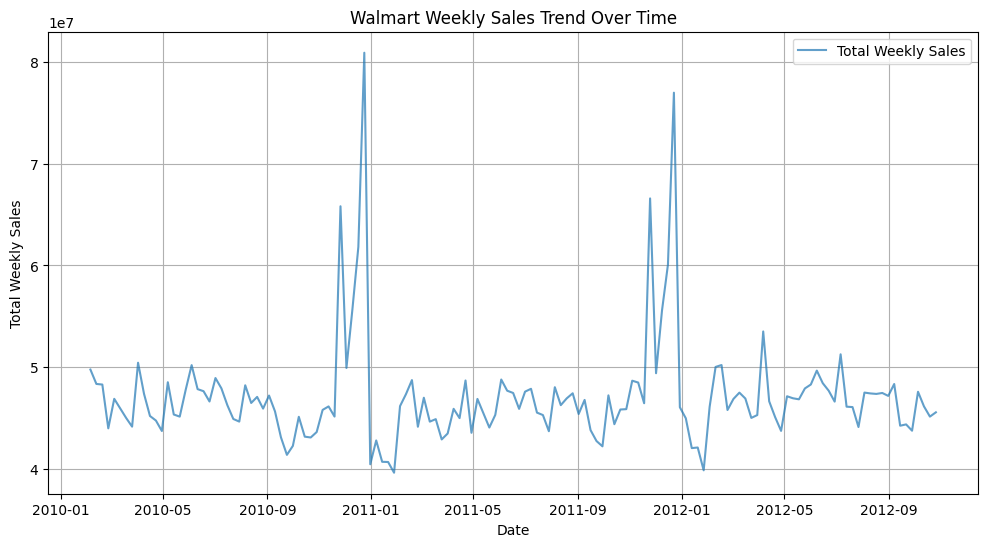

In [39]:

# Aggregate total weekly sales per Date
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Plot total sales over time
plt.figure(figsize=(12,6))
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label='Total Weekly Sales', color='tab:blue', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.title("Walmart Weekly Sales Trend Over Time")
plt.legend()
plt.grid(True)
plt.savefig("Sales_Trends_Over_Time.jpg", format="jpg", dpi=300)
plt.show()


Graph observations:

1. **Seasonal Peaks** – There are **sharp spikes** in sales, particularly around the **end of each year**. This suggests that major shopping events, such as **Black Friday and holiday sales**, significantly impact sales figures.
2. **General Fluctuations** – While sales remain relatively stable throughout the time period, **there are noticeable fluctuations** that might correspond to promotional periods, economic conditions, or external factors affecting consumer spending.
3. **Downward Trends** – The beginning of the dataset (2010) shows relatively **higher variance**, with some downward trends visible over time. This could indicate changes in store performance, economic conditions, or shifts in consumer behavior.
4. **Post-Holiday Declines** – After each peak, sales **drop sharply**, suggesting that consumers **spend significantly more during peak shopping seasons** and cut back afterward.

### Sales Distribution by Store

Goal: Find which stores generate the most revenue and spot outliers.

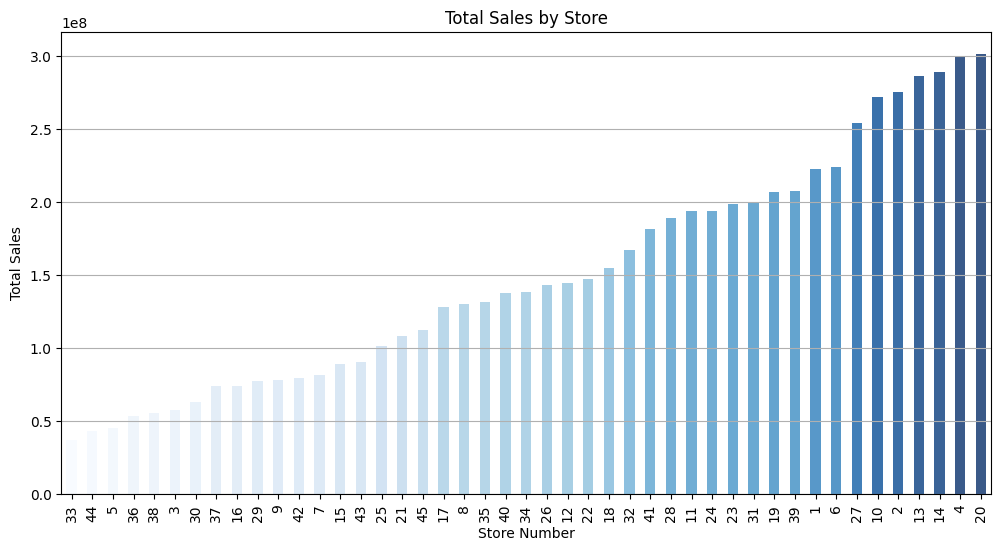

In [40]:

# Aggregate total sales per store
store_sales = train.groupby('Store')['Weekly_Sales'].sum().sort_values()

# Normalize values for color mapping
norm = plt.Normalize(store_sales.min(), store_sales.max())
colors = plt.cm.Blues(norm(store_sales))  # Change 'viridis' to other colormaps (e.g., 'coolwarm', 'plasma', 'cividis')

# Create the bar plot with varying colors
plt.figure(figsize=(12,6))
store_sales.plot(kind='bar', color=colors, alpha=0.8)

# Labels and title
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.title("Total Sales by Store")

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Grid for clarity
plt.grid(axis='y')

# Save and Show
plt.savefig("Sales_Dist_By_Store.jpg", format="jpg", dpi=300)
plt.show()


1. **Wide Range of Sales Performance**  
   - There is a **significant disparity** in total sales between stores.  
   - The lowest-performing stores have total sales below **$50,000,000**, whereas the highest-performing stores exceed **$300,000,000**.

2. **Top-Performing Stores**  
   - The rightmost bars represent **high-revenue stores**, with Store **20, 14, 4, 13, and 2** among the top earners.  
   - These stores have total sales ranging from approximately **$250,000,000 to $310,000,000**.

3. **Lowest-Performing Stores**  
   - The leftmost bars (e.g., Stores **33, 44, 5**) indicate locations with **substantially lower sales**, potentially due to **smaller customer bases, lower foot traffic, or regional economic factors**.  
   - These stores have total sales well under **$50,000,000**, with the lowest ones close to **$40,000,000**.

4. **Smooth Gradient in Sales**  
   - The **Blues colormap** visually emphasizes the progression from **low to high sales**, making it clear that **certain stores contribute disproportionately to total revenue**.  
   - There is a **steady increase in sales**, suggesting that sales performance is not random but influenced by specific factors like **location, demographics, and store size**.

5. **Possible Business Implications**  
   - **Investigate what makes the top stores successful** (e.g., location, promotions, store size, inventory variety).  
   - **Identify challenges in lower-performing stores** (e.g., competition, demographics, operational inefficiencies).  
   - **Optimize store allocation, marketing, or inventory** based on regional performance to improve sales for underperforming stores.

### **Potential Next Steps**
- **Compare rankings with store size and foot traffic data** to determine **store efficiency**.  
- **Analyze seasonality in sales** across top vs. bottom-performing stores to detect **patterns in consumer behavior**.  
- **Evaluate external factors** like **CPI, Unemployment, or regional economic indicators** to see how they correlate with store performance and adjust strategies accordingly.  

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


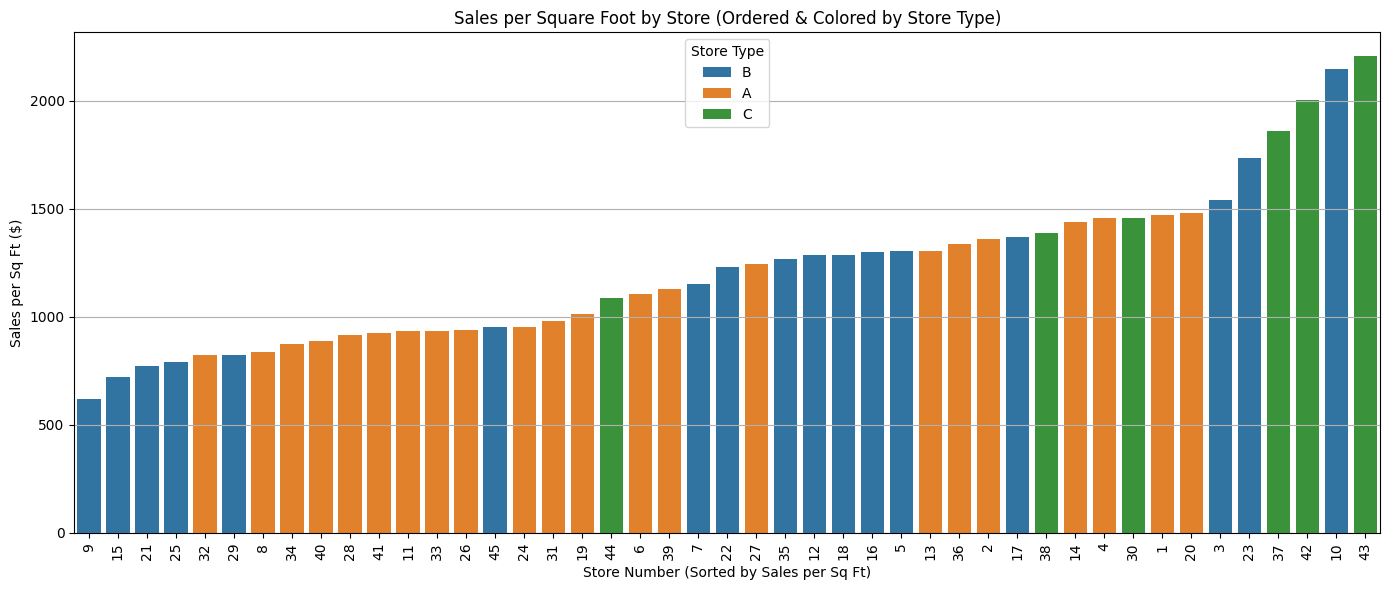

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Aggregate total sales and get unique store info
store_summary = (
    train.groupby("Store", as_index=False)
         .agg({
             "Weekly_Sales": "sum",
             "Size": "first",
             "Type": "first"
         })
)

# Step 2: Calculate sales per square foot
store_summary["Sales_per_sqft"] = store_summary["Weekly_Sales"] / store_summary["Size"]

# Step 3: Sort by Sales_per_sqft and convert Store to categorical for ordered plotting
store_summary.sort_values("Sales_per_sqft", inplace=True)
store_summary["Store"] = store_summary["Store"].astype(str)  # Convert to string for better x-tick labels
store_summary["Store"] = pd.Categorical(store_summary["Store"], categories=store_summary["Store"], ordered=True)

# Step 4: Plot with sorted x-axis
plt.figure(figsize=(14,6))
sns.barplot(data=store_summary, x="Store", y="Sales_per_sqft", hue="Type", dodge=False)

# Format plot
plt.title("Sales per Square Foot by Store (Ordered & Colored by Store Type)")
plt.xlabel("Store Number (Sorted by Sales per Sq Ft)")
plt.ylabel("Sales per Sq Ft ($)")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.legend(title="Store Type")
plt.tight_layout()
plt.show()


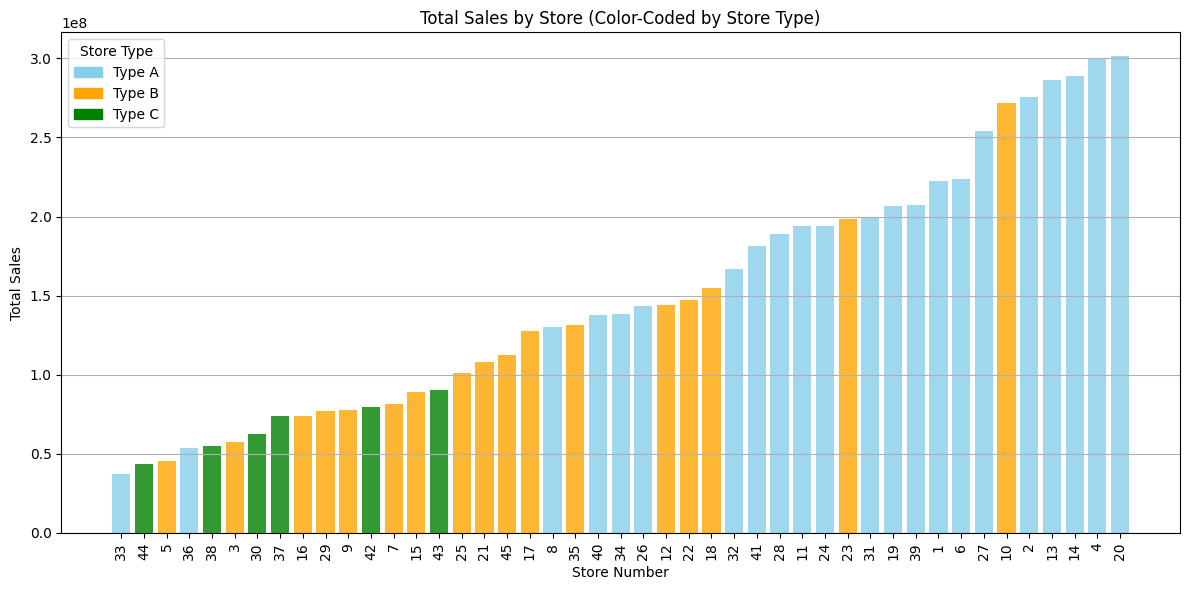

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Aggregate total sales per store
store_sales = train.groupby('Store')['Weekly_Sales'].sum().sort_values().reset_index()

# Step 2: Merge with store metadata to get 'Type'
store_metadata = stores[['Store', 'Type']]  # assuming your store info is in a DataFrame called 'stores'
store_sales = store_sales.merge(store_metadata, on='Store')

# Step 3: Assign colors to each type
type_colors = {'A': 'skyblue', 'B': 'orange', 'C': 'green'}
store_sales['Color'] = store_sales['Type'].map(type_colors)

# Step 4: Plot
plt.figure(figsize=(12,6))
plt.bar(store_sales['Store'].astype(str), store_sales['Weekly_Sales'], color=store_sales['Color'], alpha=0.8)

# Step 5: Formatting
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.title("Total Sales by Store (Color-Coded by Store Type)")
plt.xticks(rotation=90)
plt.grid(axis='y')

# Step 6: Custom Legend
handles = [plt.Rectangle((0,0),1,1, color=col) for col in type_colors.values()]
labels = [f"Type {t}" for t in type_colors.keys()]
plt.legend(handles, labels, title="Store Type")

# Step 7: Save and Show
plt.tight_layout()
plt.savefig("Sales_By_Store_Type_Overlay.jpg", format="jpg", dpi=300)
plt.show()

### Impact of CPI and Unemployment on Sales

Goal: Understand if economic conditions affect Walmart sales.


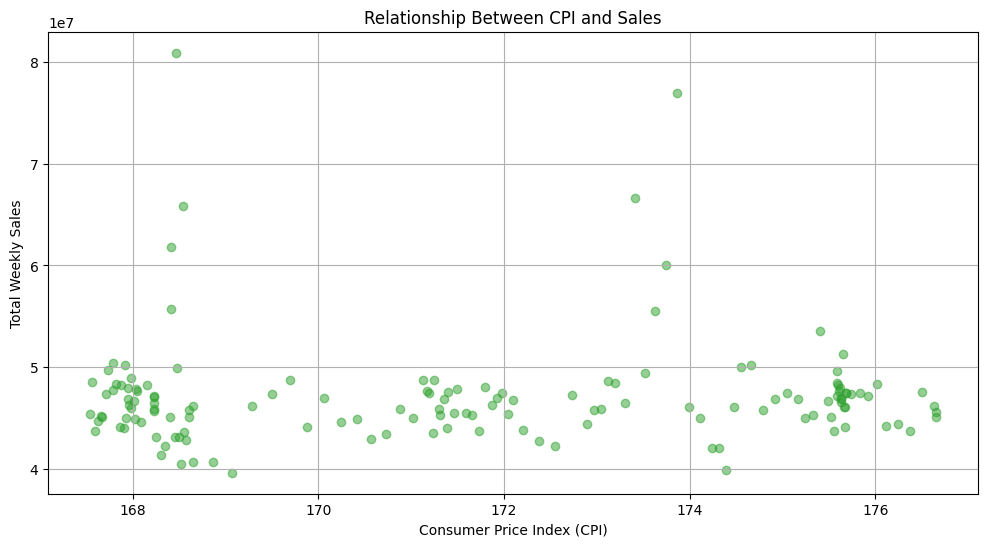

In [43]:

# Aggregate CPI to match sales data (average CPI per Date)
cpi_avg = features.groupby('Date', as_index=False)['CPI'].mean()

# Aggregate Weekly Sales to match CPI data (sum sales per Date)
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Merge CPI and Sales so both have the same number of rows
cpi_sales = pd.merge(cpi_avg, weekly_sales, on='Date')

# Scatter plot
plt.figure(figsize=(12,6))
plt.scatter(cpi_sales['CPI'], cpi_sales['Weekly_Sales'], color='tab:green', alpha=0.5)
plt.xlabel("Consumer Price Index (CPI)")
plt.ylabel("Total Weekly Sales")
plt.title("Relationship Between CPI and Sales")
plt.grid(True)
plt.savefig(f"Sales_vs_CPI.jpg", format="jpg", dpi=300)
plt.show()


Observations:

1. **No Clear Linear Trend**  
   - The points appear **widely scattered** without a strong upward or downward trend.
   - This suggests **no obvious correlation** between CPI and sales.

2. **Sales Clustering at Specific CPI Ranges**  
   - Most points are concentrated around **CPI values between 167 and 176**.
   - Weekly sales tend to hover between **$40M and $50M**, with some outliers exceeding **$80M**.

3. **Spikes in Sales at Certain CPI Levels**  
   - A few points **above $70M in weekly sales** appear at **both lower and higher CPI values**.
   - These spikes could correspond to **holiday shopping seasons, promotions, or macroeconomic factors**.

4. **Potential Business Implications**  
   - If CPI affects consumer purchasing power, we might expect **higher CPI to reduce sales**, but no clear pattern supports that hypothesis.
   - Other factors, such as **holidays, markdowns, fuel prices, or unemployment rates**, may be more significant influences on Walmart sales.

### **Next Steps for Analysis**
- **Compute the correlation coefficient** between CPI and total sales to **quantify** the relationship.
- **Color-code points based on seasons or promotions** to check if spikes align with major events.
- **Compare this with an Unemployment vs. Sales scatter plot** to see which factor has a stronger impact.


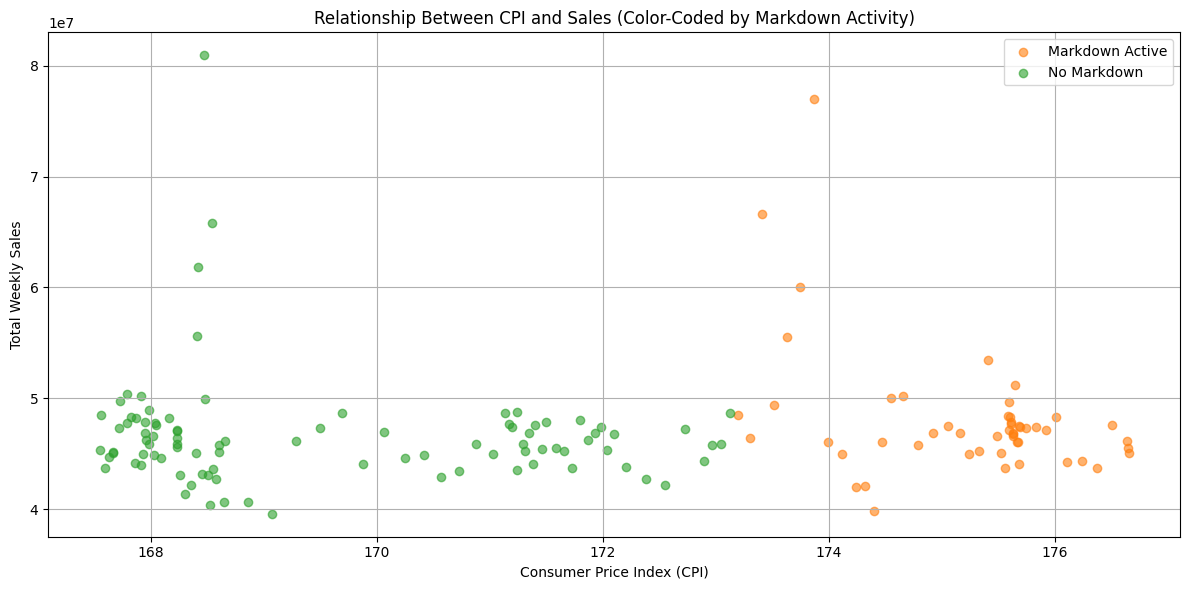

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Aggregate CPI per Date
cpi_avg = features.groupby('Date', as_index=False)['CPI'].mean()

# Step 2: Aggregate total Weekly Sales per Date
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Step 3: Create a flag for markdown activity
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train['Any_Markdown'] = train[markdown_cols].fillna(0).sum(axis=1) > 0
markdown_flags = train.groupby('Date', as_index=False)['Any_Markdown'].any()

# Step 4: Merge into one DataFrame
cpi_sales = (
    cpi_avg
    .merge(weekly_sales, on='Date')
    .merge(markdown_flags, on='Date')
)

# Step 5: Plot with correct colors
plt.figure(figsize=(12,6))

# Use fixed color values
plt.scatter(
    cpi_sales[cpi_sales['Any_Markdown'] == True]['CPI'],
    cpi_sales[cpi_sales['Any_Markdown'] == True]['Weekly_Sales'],
    color='tab:orange', label='Markdown Active', alpha=0.6
)

plt.scatter(
    cpi_sales[cpi_sales['Any_Markdown'] == False]['CPI'],
    cpi_sales[cpi_sales['Any_Markdown'] == False]['Weekly_Sales'],
    color='tab:green', label='No Markdown', alpha=0.6
)

# Plot formatting
plt.xlabel("Consumer Price Index (CPI)")
plt.ylabel("Total Weekly Sales")
plt.title("Relationship Between CPI and Sales (Color-Coded by Markdown Activity)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Sales_vs_CPI_Markdown_Color.jpg", format="jpg", dpi=300)
plt.show()


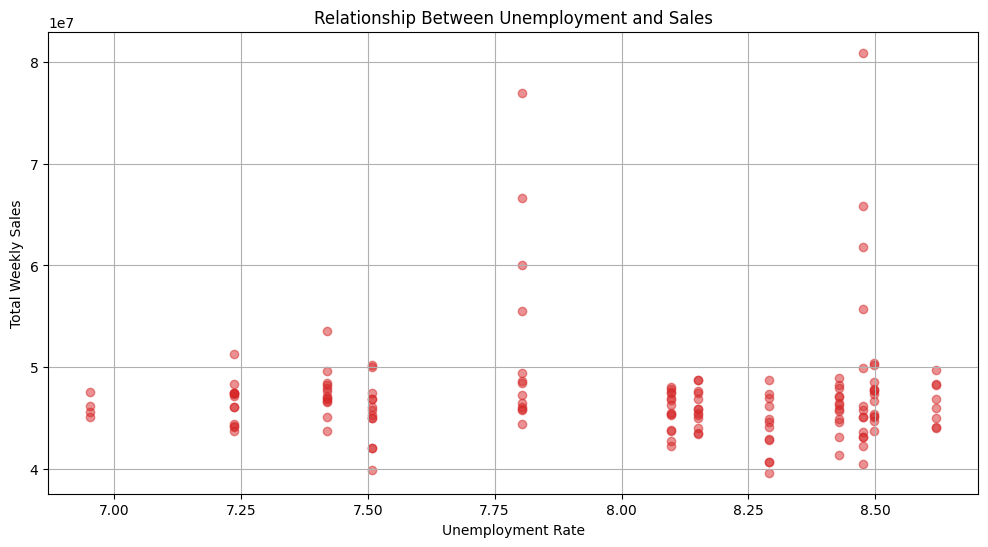

In [45]:

# Aggregate Unemployment to match sales data (average Unemployment per Date)
unemployment_avg = features.groupby('Date', as_index=False)['Unemployment'].mean()

# Aggregate Weekly Sales to match Unemployment data (sum sales per Date)
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Merge Unemployment and Sales so both have the same number of rows
unemp_sales = pd.merge(unemployment_avg, weekly_sales, on='Date')

# Scatter plot
plt.figure(figsize=(12,6))
plt.scatter(unemp_sales['Unemployment'], unemp_sales['Weekly_Sales'], color='tab:red', alpha=0.5)
plt.xlabel("Unemployment Rate")
plt.ylabel("Total Weekly Sales")
plt.title("Relationship Between Unemployment and Sales")
plt.grid(True)
plt.savefig(f"Sales_vs_Unemployment.jpg", format="jpg", dpi=300)
plt.show()

Observations:

1. **No Strong Trend Between Unemployment and Sales**  
   - The points are **widely scattered** with no clear upward or downward pattern.
   - This suggests **no obvious correlation** between unemployment and weekly sales.

2. **Sales Remain Relatively Stable Across Unemployment Levels**  
   - Most sales values cluster between **$40M** and **$50M** across different unemployment rates.
   - A few extreme values (above **$80M**) occur at various unemployment levels, indicating **other factors influencing sales spikes** (e.g., holiday seasons or promotions).

3. **Higher Sales Spikes Around 7.75% and 8.5% Unemployment**  
   - A few **outlier sales points** above **$70M** appear when unemployment is at **7.75% and 8.5%**.
   - This could mean that **seasonal events** or **government stimulus programs** influenced consumer spending at certain unemployment levels.

4. **Potential Business Implications**  
   - If unemployment were a major driver of sales, we might expect lower sales when unemployment is high. However, this graph does not **clearly support that hypothesis**.
   - Walmart’s sales may be **resilient** to unemployment fluctuations due to its position as a discount retailer (people may shop more at Walmart when economic conditions worsen).

### **Next Steps for Further Analysis**
- **Compute the correlation coefficient** to measure the strength of the relationship between unemployment and sales.
- **Overlay a trend line** to check for subtle patterns.
- **Segment data by year or season** to see if the relationship changes during economic downturns or major events.
- **Compare this with the CPI vs. Sales graph** to determine which economic indicator has a stronger impact.

Would you like to add **trend lines or color code the points based on seasons**? 📊

### Sales Comparison: Holiday vs. Non-Holiday Weeks

Goal: Measure the impact of holidays on sales.

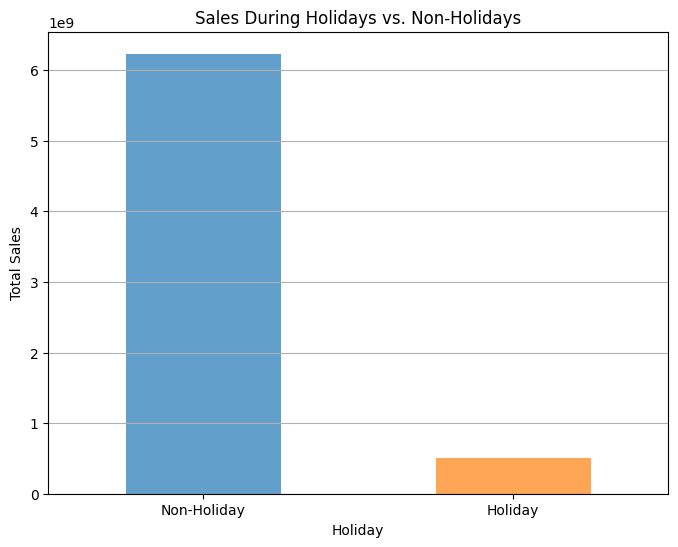

In [46]:
holiday_sales = train.groupby('Holiday')['Weekly_Sales'].sum()
plt.figure(figsize=(8,6))
holiday_sales.plot(kind='bar', color=['tab:blue', 'tab:orange'], alpha=0.7)
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.ylabel("Total Sales")
plt.title("Sales During Holidays vs. Non-Holidays")
plt.grid(axis='y')
plt.savefig("Holiday_Sales.jpg", format="jpg", dpi=300)
plt.show()

Observations:
1. **Sales Are Significantly Higher on Non-Holiday Weeks**  
   - Non-holiday weeks contribute **over $6 billion** in total sales, while holiday weeks contribute **significantly less**.
   - This may seem counterintuitive because holidays often see shopping spikes, but Walmart operates year-round, and **non-holiday weeks outnumber holiday weeks**, leading to higher cumulative sales.

2. **Holiday Sales Are Noticeably Lower in Total**  
   - Despite known shopping surges on holidays like **Black Friday or Christmas**, the total sales from these weeks appear **much lower** compared to non-holiday weeks.
   - This could be due to **fewer holiday weeks overall** rather than lower individual weekly sales.

3. **Potential Explanations for This Trend**  
   - The dataset might define **holidays too narrowly**, possibly including only major U.S. holidays (e.g., Christmas, Thanksgiving, Labor Day) and **excluding other high-sales periods like back-to-school shopping**.
   - Holiday shopping spikes may be offset by **weeks of buildup purchases** leading to sales spread across multiple weeks.

#### **Business Implications:**
- **Adjust Holiday Definitions:**  
  - Reevaluate how holidays are defined in the dataset. Including events like **Black Friday weekends** or **pre-holiday shopping periods** might change the comparison.
  
- **Look at Per-Week Sales Instead of Total Sales:**  
  - Instead of aggregating total sales, a **per-week comparison** might reveal whether holiday weeks have higher sales per week compared to non-holiday weeks.

- **Segment Holidays Individually:**  
  - Break down the analysis by **specific holidays** to see which ones actually drive Walmart’s sales the most.

### Store Performance Over Time (Top 5 & Bottom 5)

Goal: Compare high-performing vs. low-performing stores.

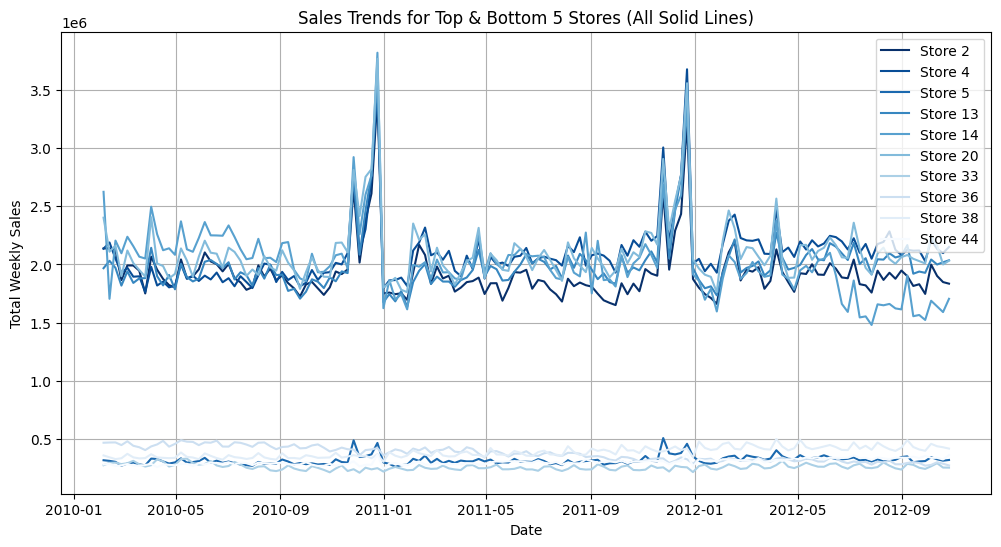

In [47]:
import matplotlib.cm as cm  # Import colormap module

# Get total sales per store
store_totals = train.groupby("Store")["Weekly_Sales"].sum().sort_values()

# Select top 5 and bottom 5 stores
top_stores = store_totals.tail(5).index
bottom_stores = store_totals.head(5).index

# Filter the dataset for these stores & aggregate sales per date
top_bottom_df = (
    train[train["Store"].isin(top_stores.union(bottom_stores))]
    .groupby(["Date", "Store"], as_index=False)["Weekly_Sales"]
    .sum()
)

# Sort by Date to ensure proper plotting
top_bottom_df.sort_values("Date", inplace=True)

# Generate a colormap with smooth gradient transition
num_colors = len(top_stores) + len(bottom_stores)  # Number of unique colors needed
colors = cm.Blues_r(np.linspace(0, 1, num_colors))  # Smooth color gradient from viridis

plt.figure(figsize=(12,6))

# Plot both top and bottom stores with solid lines
for i, store in enumerate(top_stores.union(bottom_stores)):  # Combine both lists
    subset = top_bottom_df[top_bottom_df["Store"] == store]
    plt.plot(subset["Date"], subset["Weekly_Sales"], 
             label=f"Store {store}", color=colors[i])

# Formatting
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.title("Sales Trends for Top & Bottom 5 Stores (All Solid Lines)")
plt.legend()
plt.grid(True)
plt.savefig("Top_and_Bottom_Stores.jpg", format="jpg", dpi=300)
plt.show()



1. **Comparison of Top vs. Bottom Stores**:
   - The **top 5 stores** have significantly higher total weekly sales, consistently staying above **1.5M** in weekly sales.
   - The **bottom 5 stores** exhibit much lower sales, staying **below 500K** weekly.
   - The separation in sales between the top and bottom stores is **clearly visible**.

2. **Seasonal Spikes**:
   - There are **sharp spikes in sales** at certain points, likely corresponding to holiday seasons or major sales events (e.g., Black Friday).
   - The **top stores** experience **higher magnitude spikes** compared to the bottom stores.

3. **Sales Stability**:
   - **Top stores** show a more **consistent trend** with fluctuations.
   - **Bottom stores** have a **flatter trend** with very little variation over time.

4. **Use of Line Colors**:
   - The **darker lines represent higher sales stores**, while the **lighter lines represent lower sales stores**.
   - This color contrast effectively differentiates performance levels.

### Sales Trends by Store Type


Why? Store types (A, B, C) likely have different sales patterns. This can help determine which store types are performing better.

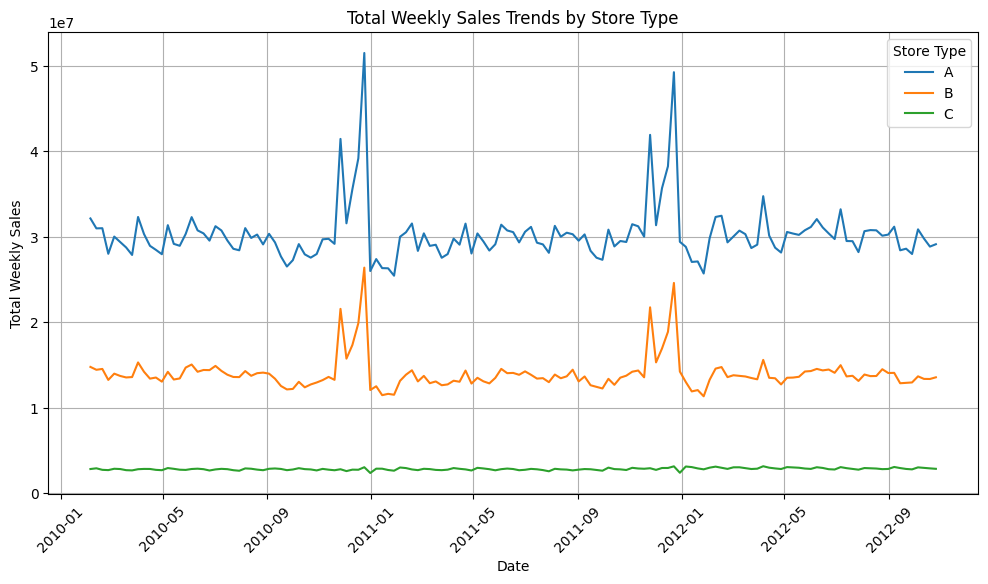

In [48]:
import seaborn as sns
import warnings

# Suppress only FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Group data properly
train_grouped = train.groupby(['Date', 'Type'], as_index=False)['Weekly_Sales'].sum()

# Plot sales trends by store type
plt.figure(figsize=(12,6))
sns.lineplot(data=train_grouped, x='Date', y='Weekly_Sales', hue='Type')

# Formatting
plt.title("Total Weekly Sales Trends by Store Type")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("Sales_Trend_by_Store_Type.jpg", format="jpg", dpi=300)
plt.show()


1. **Sales Distribution Across Store Types**:
   - **Type A stores** (blue) generate the highest total weekly sales, significantly outperforming the other store types.
   - **Type B stores** (orange) have moderate sales but still show seasonal peaks.
   - **Type C stores** (green) contribute the least to total weekly sales.

2. **Seasonal Sales Peaks**:
   - There are **noticeable spikes in sales** at certain intervals, likely coinciding with major shopping events (e.g., Black Friday, holiday sales).
   - These spikes are **more pronounced for Type A and B stores**, whereas Type C stores remain relatively stable.

3. **Overall Trend**:
   - **Type A stores show a slight downward trend** over time, indicating either market saturation or external economic factors.
   - **Type B stores maintain relatively steady sales** with minor fluctuations.
   - **Type C stores remain consistently low**, indicating they cater to a smaller customer base.

4. **Legend & Color Usage**:
   - The **legend effectively distinguishes between store types**.
   - The **colors are well-chosen** to differentiate trends without confusion.

### **Potential Enhancements**:
✅ Add **trend lines** to show long-term sales direction.  
✅ Include **annotations** for key sales events to improve insights.  

### Impact of Store Size on Sales

Why? Larger stores may have higher sales, but does size correlate with better performance?

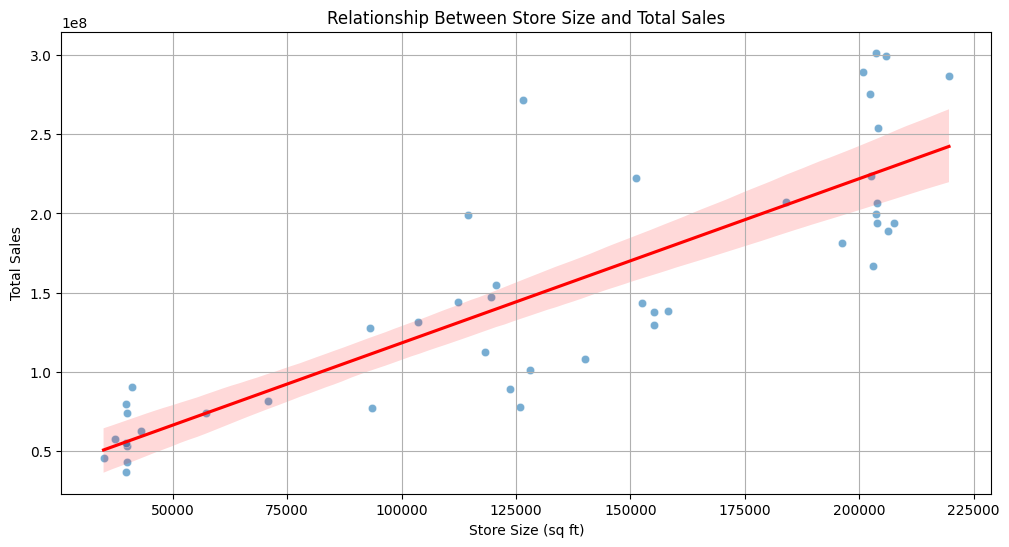

In [49]:
# Ensure 'Size' is included in the groupby result
store_sales_size = train.groupby("Store", as_index=False).agg({
    "Weekly_Sales": "sum",
    "Size": "first"  # Retain each store's Size value
})

# Plot the scatterplot with regression line
plt.figure(figsize=(12,6))
sns.scatterplot(data=store_sales_size, x="Size", y="Weekly_Sales", alpha=0.6)
sns.regplot(data=store_sales_size, x="Size", y="Weekly_Sales", scatter=False, color='red')

plt.title("Relationship Between Store Size and Total Sales")
plt.xlabel("Store Size (sq ft)")
plt.ylabel("Total Sales")
plt.grid(True)
plt.savefig("Impact_of_Store_Size_on_Sales.jpg", format="jpg", dpi=300)
plt.show()

1. **Positive Correlation**:
   - The **scatter plot** shows a clear **positive correlation** between store size and total sales.
   - As the **store size increases**, the **total sales tend to be higher**.

2. **Regression Line**:
   - The **red regression line** suggests a strong **linear relationship**.
   - The **shaded confidence interval** around the regression line indicates a **moderate variance** in the relationship.

3. **Outliers**:
   - Some **large stores** (above ~175,000 sq ft) **do not fit the trend perfectly**, showing variation in sales.
   - Similarly, a few **small stores** (below ~50,000 sq ft) also show slightly higher sales than expected.

4. **Key Takeaways**:
   - **Larger stores tend to generate more total sales**, reinforcing the idea that store size is a major driver of revenue.
   - However, **store size alone is not the only factor**—there are still variations in sales across similar-sized stores.

---

### **Potential Enhancements**:
✅ **Color-code points based on store type** to see if Type A, B, and C stores follow different sales patterns.  
✅ **Annotate outliers** to analyze why they perform better/worse than expected.  
✅ **Use a polynomial regression** to check if the relationship is slightly non-linear.

### Sales vs. Fuel Price

Why? Changes in fuel prices might impact shopping behavior, especially for distant stores.

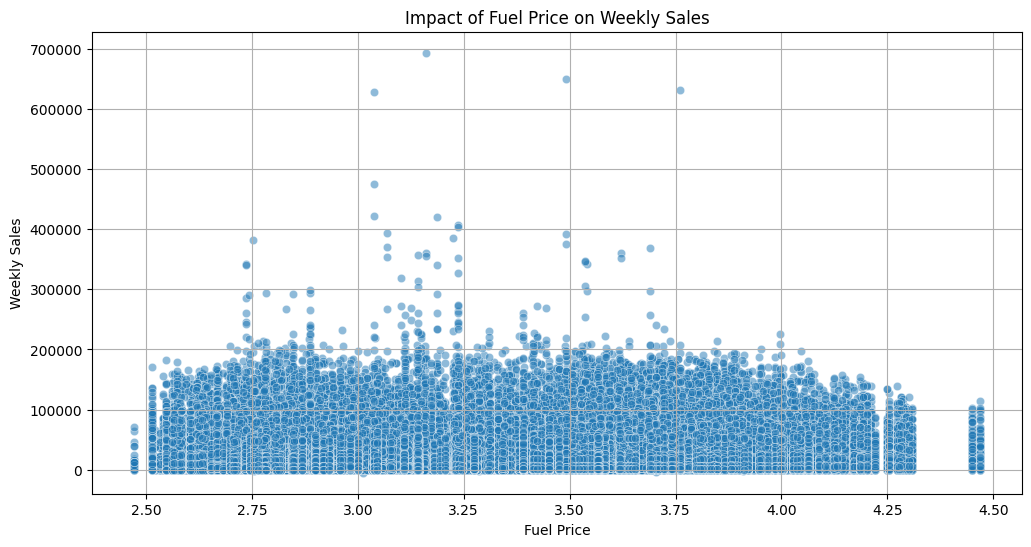

In [50]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=train, x='Fuel_Price', y='Weekly_Sales', alpha=0.5)
# sns.regplot(data=train, x='Fuel_Price', y='Weekly_Sales', scatter=False, color='red')
plt.title("Impact of Fuel Price on Weekly Sales")
plt.xlabel("Fuel Price")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.savefig("Sales_vs_Fuel_Price.jpg", format="jpg", dpi=300)
plt.show()


1. **No Clear Relationship**:
   - The scatter plot remains **widely dispersed**, showing no **strong correlation** between fuel price and weekly sales.
   - **Sales remain relatively stable** regardless of fluctuations in fuel prices.

2. **No Regression Line**:
   - Unlike the previous version, this graph **does not include a regression trendline**.
   - This might help in reducing visual clutter, but also removes any indication of a weak trend.

3. **Outliers & Dense Clusters**:
   - Sales data points are densely packed between **$2.50 - $3.75 fuel price range**, showing **higher activity** in this range.
   - Outliers still exist, with **some extremely high sales spikes** spread across different fuel prices.

4. **Key Insights**:
   - **Fuel price does not significantly influence sales** in a direct way.
   - Other factors like **holidays, markdowns, store type, and economic conditions** likely play a bigger role in driving Walmart sales.
   

### **Possible Enhancements**:
✅ **Color-code data points by Store Type** to check if certain store types are more affected by fuel price.  
✅ **Add a trendline or rolling average** to check for subtle trends.  
✅ **Use a log-scale on the y-axis** to better visualize smaller variations.

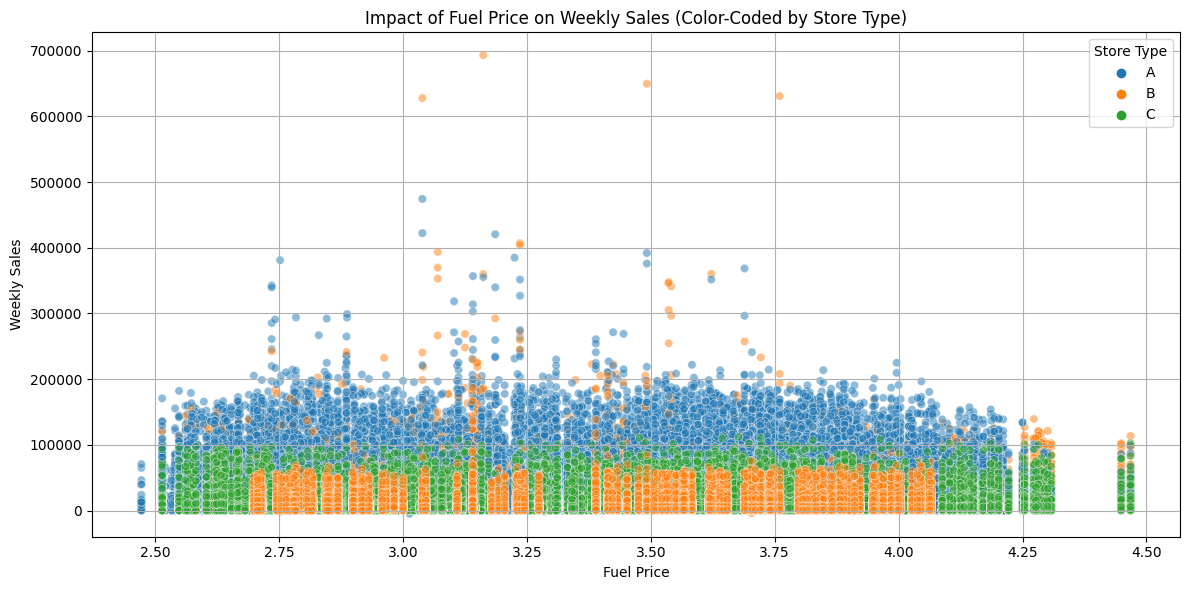

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

# Scatterplot with store type as hue
sns.scatterplot(data=train, x='Fuel_Price', y='Weekly_Sales', hue='Type', alpha=0.5)

# Formatting
plt.title("Impact of Fuel Price on Weekly Sales (Color-Coded by Store Type)")
plt.xlabel("Fuel Price")
plt.ylabel("Weekly Sales")
plt.legend(title="Store Type")
plt.grid(True)
plt.tight_layout()
plt.savefig("Sales_vs_Fuel_Price_by_Type.jpg", format="jpg", dpi=300)
plt.show()


### Sales Trends During Markdown Periods

Why? Understanding how markdowns impact sales can be crucial for promotional strategies.

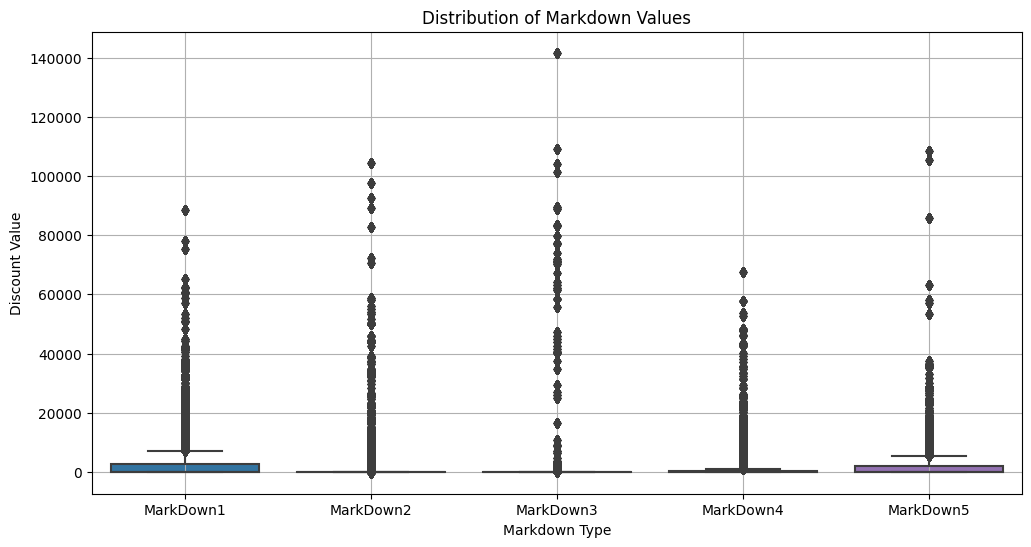

In [52]:
plt.figure(figsize=(12,6))
sns.boxplot(data=train.melt(id_vars=['Weekly_Sales'], value_vars=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']),
            x='variable', y='value')
plt.title("Distribution of Markdown Values")
plt.xlabel("Markdown Type")
plt.ylabel("Discount Value")
plt.grid(True)
plt.savefig("Markdown_Distribution.jpg", format="jpg", dpi=300)
plt.show()

1. **Outliers** – There are many high-value outliers across all markdown types, indicating that markdown values can occasionally be very large.
2. **Skewed Distribution** – Most markdown values are concentrated near zero, suggesting that high markdown values are rare.
3. **Variation Among Types** – MarkDown1 and MarkDown5 appear to have more variation in markdown values compared to MarkDown2, MarkDown3, and MarkDown4, which remain close to zero.

### Suggested Improvements:
- **Use a Log Scale:** Since markdown values have extreme outliers, using a logarithmic scale on the y-axis (e.g., `plt.yscale('log')`) can better highlight differences across markdown types.
- **Add a Violin Plot:** A violin plot can help visualize the density of markdown values better than a standard box plot.
- **Color Variation:** Different colors for each markdown type would improve readability.
- **Remove Extreme Outliers:** If extreme values make it difficult to see trends, consider filtering out the highest percentiles (e.g., 99th percentile).

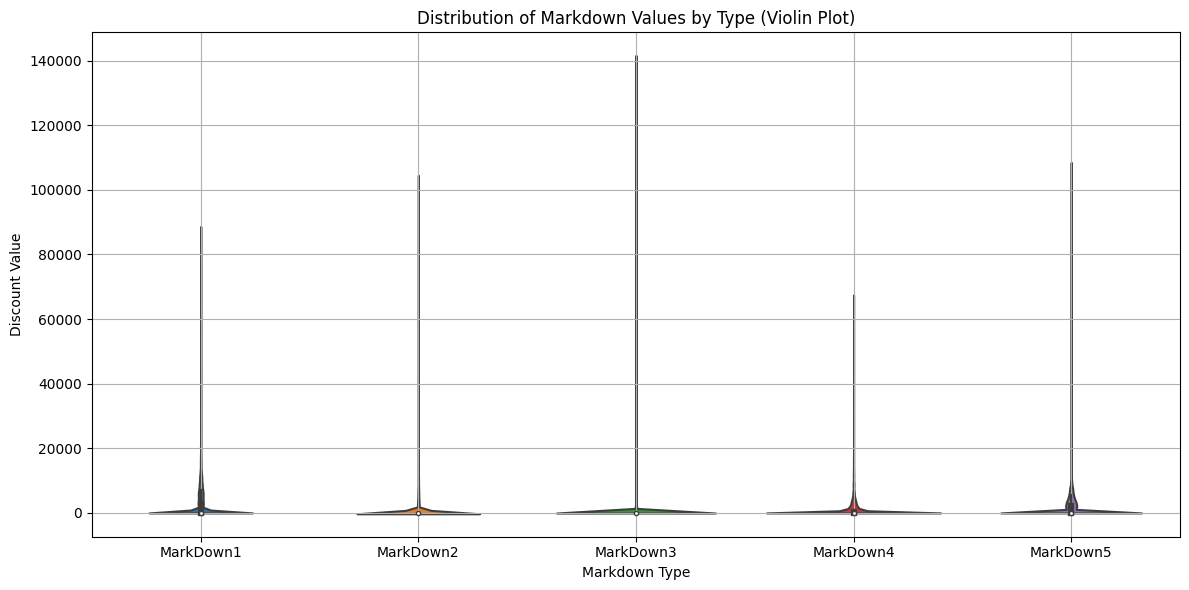

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the markdown columns into long format
melted_md = train.melt(
    id_vars=['Weekly_Sales'],
    value_vars=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'],
    var_name='Markdown Type',
    value_name='Discount Value'
)

# Create violin plot
plt.figure(figsize=(12,6))
sns.violinplot(data=melted_md, x='Markdown Type', y='Discount Value', inner='box', cut=0)

# Formatting
plt.title("Distribution of Markdown Values by Type (Violin Plot)")
plt.xlabel("Markdown Type")
plt.ylabel("Discount Value")
plt.grid(True)
plt.tight_layout()
plt.savefig("Markdown_Distribution_Violin.jpg", format="jpg", dpi=300)
plt.show()

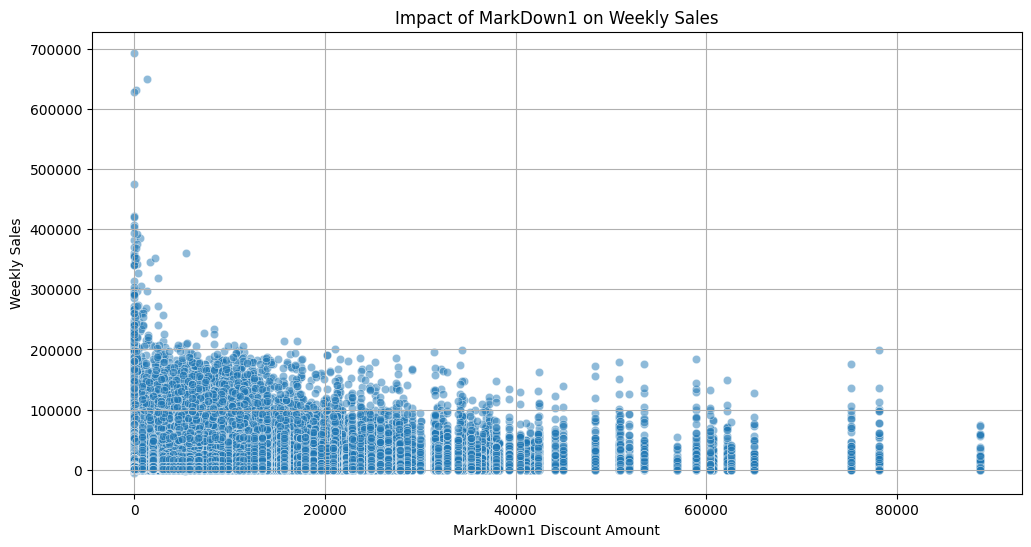

In [54]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=train, x='MarkDown1', y='Weekly_Sales', alpha=0.5)
# sns.regplot(data=train, x='MarkDown1', y='Weekly_Sales', scatter=False, color='red')
plt.title("Impact of MarkDown1 on Weekly Sales")
plt.xlabel("MarkDown1 Discount Amount")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.savefig("Markdown1_Impact_on_Sales.jpg", format="jpg", dpi=300)
plt.show()

1. **Inverse Relationship:** 
   - There is a noticeable **decline** in weekly sales as markdown values increase, suggesting that **higher markdowns might not necessarily lead to significantly higher sales**.
   - A **large number of points** are clustered at **low markdown values** and **high sales**, indicating that regular sales (without markdowns) contribute significantly to revenue.

2. **Heavy Concentration at Low Markdowns:**  
   - Most sales occur when markdowns are **low (near 0)**, showing that markdowns are not always necessary to generate high revenue.
   - A few extreme markdown values exist, but their impact on sales appears **less significant**.

3. **Outliers and High Discount Cases:**  
   - There are instances of very high markdowns (above **60,000+**), but **sales do not show a strong corresponding increase**.
   - These might be **special cases, bulk promotions, or clearance events**.

#### **Suggested Improvements:**
1. **Use Log Scale for MarkDown1:**  
   - A **logarithmic scale** for the x-axis (`plt.xscale("log")`) can help visualize the lower markdown values more effectively.
   
2. **Overlay a Trend Line:**  
   - A regression line (or LOWESS smooth curve) can provide better insight into the overall trend between markdowns and sales.

3. **Separate High and Low Sales Segments:**  
   - It might be useful to **bin markdown values** into different categories (low, medium, high) to analyze their impact on sales separately.

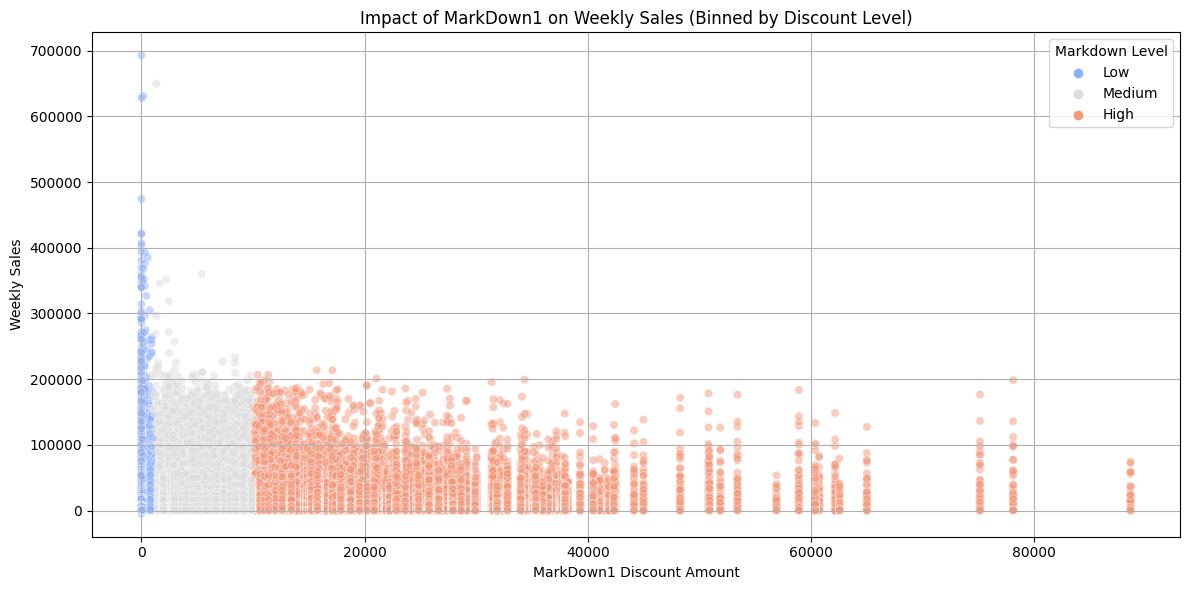

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create Markdown1 bins (e.g., tertiles or custom bins)
train['MarkDown1_Binned'] = pd.cut(
    train['MarkDown1'].fillna(0),  # handle NaNs as 0
    bins=[-1, 1000, 10000, train['MarkDown1'].max()],
    labels=['Low', 'Medium', 'High']
)

# Plot
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=train, 
    x='MarkDown1', 
    y='Weekly_Sales', 
    hue='MarkDown1_Binned', 
    alpha=0.5,
    palette='coolwarm'
)

# Optional regression line (for overall trend)
# sns.regplot(data=train, x='MarkDown1', y='Weekly_Sales', scatter=False, color='black')

# Labels and formatting
plt.title("Impact of MarkDown1 on Weekly Sales (Binned by Discount Level)")
plt.xlabel("MarkDown1 Discount Amount")
plt.ylabel("Weekly Sales")
plt.legend(title="Markdown Level")
plt.grid(True)
plt.tight_layout()
plt.savefig("Markdown1_Impact_on_Sales_Binned.jpg", format="jpg", dpi=300)
plt.show()


### Seasonal Trends in Sales

Why? Retail sales often follow seasonal patterns (e.g., holidays, back-to-school, Black Friday).

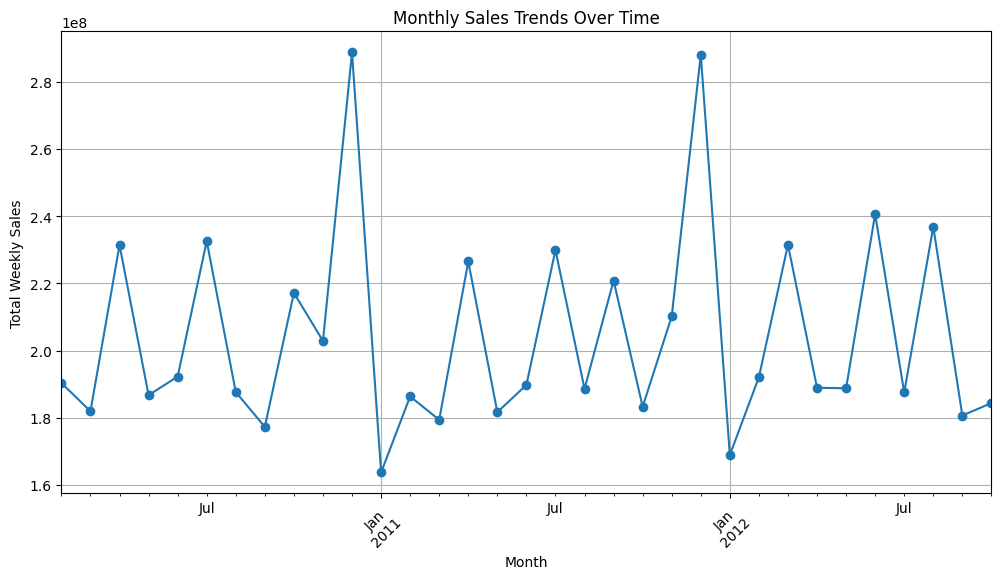

In [56]:
train['Month'] = train['Date'].dt.to_period("M")  # Extract Month-Year
monthly_sales = train.groupby("Month")["Weekly_Sales"].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', marker='o', color='tab:blue')
plt.title("Monthly Sales Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Total Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("Seasonal_Trends_in_Sales.jpg", format="jpg", dpi=300)
plt.show()

1. **Seasonal Spikes:**  
   - There are **recurring spikes in sales** around similar months each year, indicating a **seasonal trend**.
   - The highest peaks appear around **November-December**, likely corresponding to **holiday shopping seasons** (Thanksgiving, Black Friday, and Christmas).

2. **Consistent Cycles:**  
   - A repeating pattern of sales fluctuations is visible, with **higher sales peaks** followed by dips in between.
   - This suggests that consumer spending **follows a predictable trend throughout the year**.

3. **Lowest Sales Dip in Early 2011:**  
   - A significant drop in sales is noticeable around **January 2011**.
   - This could be due to a **post-holiday slump**, where customer spending slows down after the shopping rush.

4. **Growth in Sales Over Time?**  
   - There may be **gradual growth in sales**, but a clearer trend line would be needed to confirm.
   - If necessary, adding a **moving average** (e.g., 3-month or 6-month rolling average) could help **smooth out short-term fluctuations**.

#### **Possible Improvements to the Graph:**
✅ **Add a Moving Average Trendline:**  
   - A smoothed line (e.g., **rolling mean of 3 or 6 months**) can help highlight **long-term sales growth patterns**.  

✅ **Highlight Peak Seasons:**  
   - Annotating key peak months (**November-December**) could make it easier to identify high-sales periods.  

✅ **Compare Different Years:**  
   - Using **separate lines for different years** would help in comparing **year-over-year sales performance**.  

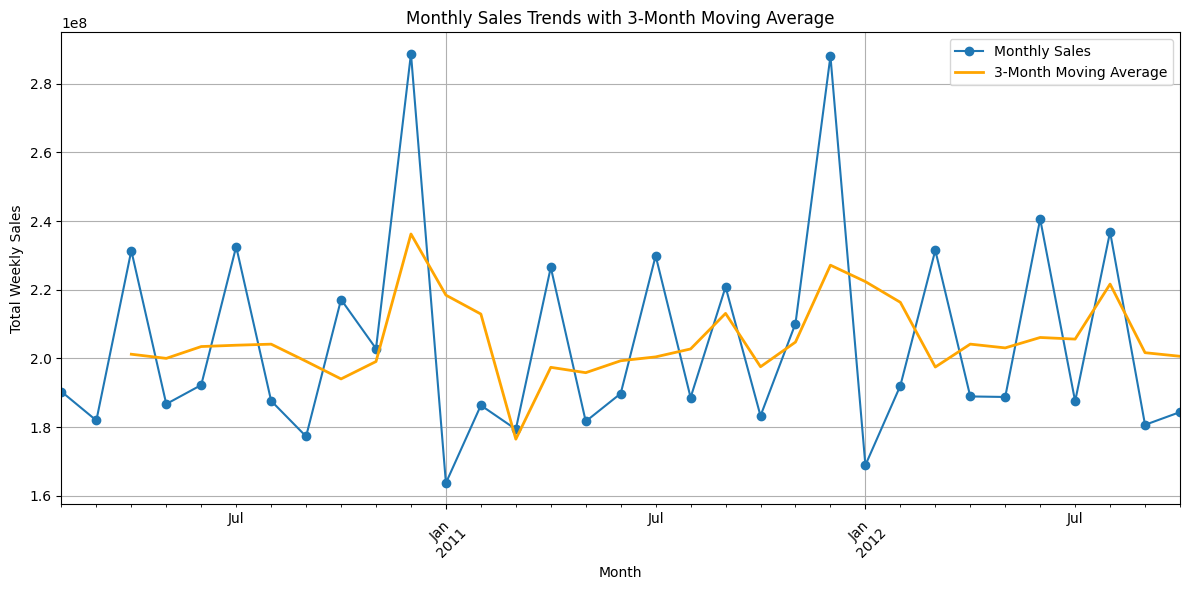

In [57]:
import matplotlib.pyplot as plt

# Extract Month-Year and group by month
train['Month'] = train['Date'].dt.to_period("M")
monthly_sales = train.groupby("Month")["Weekly_Sales"].sum()

# Convert PeriodIndex to datetime for plotting
monthly_sales.index = monthly_sales.index.to_timestamp()

# Calculate 3-month moving average
moving_avg = monthly_sales.rolling(window=3).mean()

# Plot original and moving average
plt.figure(figsize=(12,6))
monthly_sales.plot(label="Monthly Sales", marker='o', color='tab:blue')
moving_avg.plot(label="3-Month Moving Average", color='orange', linewidth=2)

# Formatting
plt.title("Monthly Sales Trends with 3-Month Moving Average")
plt.xlabel("Month")
plt.ylabel("Total Weekly Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Seasonal_Trends_in_Sales_with_MA.jpg", format="jpg", dpi=300)
plt.show()


### Comparing Holiday vs. Non-Holiday Sales

Why? Holiday periods might have a big impact on sales spikes.

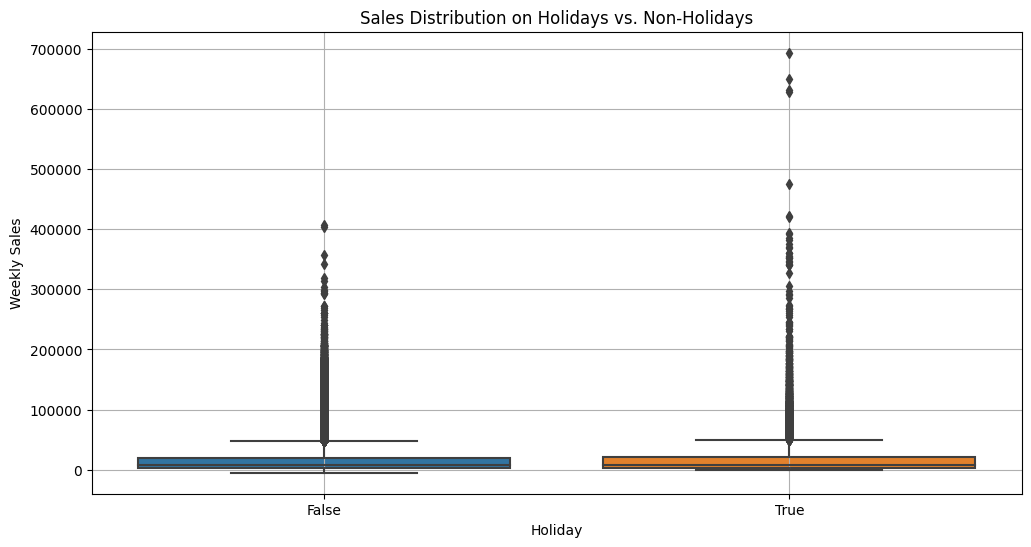

In [58]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Holiday', y='Weekly_Sales', data=train)
plt.title("Sales Distribution on Holidays vs. Non-Holidays")
plt.xlabel("Holiday")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.savefig("Holiday_Sales_Distribution.jpg", format="jpg", dpi=300)
plt.show()

1. **Outliers in Both Categories:**  
   - There are extreme **high-value outliers** in both holiday and non-holiday sales.  
   - Some sales exceed **$700,000**, indicating major shopping events.

2. **Similar Median Sales Levels:**  
   - The **median weekly sales for both holiday and non-holiday periods appear similar**.  
   - This suggests that, on average, holidays do not significantly impact weekly sales unless considering outliers.

3. **Wider Spread for Non-Holidays:**  
   - The **interquartile range (IQR)** (box width) for non-holiday sales is slightly **wider** than that of holiday sales.  
   - This suggests that **sales on non-holiday weeks are more variable**.

4. **Presence of High Holiday Sales Peaks:**  
   - The presence of multiple **high-value outliers in holiday weeks** suggests that a few holidays drive **exceptionally high sales**.  
   - Likely candidates include **Black Friday, Christmas, and Thanksgiving sales events**.

#### **Possible Improvements to the Graph:**
✅ **Use a log scale for better visibility of outliers**  
   - Since sales values have a large range, using a **logarithmic y-axis** could help make differences clearer.

✅ **Distinguish Peak Holidays**  
   - Separate different holidays (e.g., **Christmas vs. Labor Day**) instead of grouping all under one **"Holiday"** category.

✅ **Overlay Mean Sales as a Line or Point**  
   - The mean might provide additional insights into whether average sales are significantly higher during holidays.

# <span style="color:#5E6997">Conclusion</span> <a class="anchor" id="conclusion"></a>